In [1]:
import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = '/Users/artem/Documents/Projects/CIAN Real Estate/cian-sales-2018-2021.csv'

REGION_ID = 2661  # City of Saint Petersburg

MIN_AREA = 20  # Outlier range for floor area
MAX_AREA = 200

MIN_KITCHEN = 6  # Outlier range for kitchen area
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Outlier range for price
MAX_PRICE = 50_000_000

SEED = 15
N_FOLDS = 5

In [3]:
df = pd.read_csv(PATH)
print(f'Data shape: {df.shape}')
df.head()

Data shape: (5477006, 13)


,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [4]:
# Function removes excess columns and enforces correct data types. 
# :param df: Original DataFrame :return: Updated DataFrame
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df.drop('time', axis=1, inplace=True)
    # convert prices to Millions
    #df['price']=df['price']/1000000
    # Date to Datetime
    df['date'] = pd.to_datetime(df['date'])
    # Column actually contains -1 and -2 values presumably for studio apartments.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    df['price'] = df['price'].abs()  # Fix negative values
    # Drop price and area outliers.
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    # Fix kitchen area outliers.
    # At first, replace all outliers with 0.
    df.loc[(df['kitchen_area'] >= MAX_KITCHEN) | (df['area'] <= MIN_AREA), 'kitchen_area'] = 0
    # Then calculate kitchen area based on the floor area, except for studios.
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'kitchen_area'] = \
        df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'area'] * kitchen_share
    return df

In [5]:
# Function selects the listings belonging to a specified region.
#    :param df: Original DataFrame with all listings
#    :return: Filtered DataFrame
def select_region(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['region'] == REGION_ID]
    df.drop('region', axis=1, inplace=True)
    print(f'Selected {len(df)} samples in region {REGION_ID}.')
    return df

In [6]:
# add features
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Replace "date" with numeric features for year and month.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    # Apartment floor in relation to total number of floors.
    df['level_to_levels'] = df['level'] / df['levels']
    # Average size of room in the apartment.
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    # Fix division by zero.
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    return df

In [7]:
def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [8]:
# Data set contains samples with typos and errors including negative prices, 
# too large or unrealistically small floor area, etc. 
# Let's clean the data before proceeding with the analysis. 
# We limit the floor area to a range betwee 20 sq.m and 200 sq.m 
# and price to a range between 1.5 mln to 50 mln rubles, which covers most of the housing market.
df = df.pipe(clean_data)
df.shape

(4747486, 12)

In [9]:
# Run Region filter function
df_reg = df.pipe(select_region)
df_reg.shape


Selected 453621 samples in region 2661.


(453621, 11)

In [10]:
# Run add features function
df_reg_feat = df_reg.pipe(add_features)
df_reg_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453621 entries, 0 to 5476998
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   price            453621 non-null  int64  
 1   geo_lat          453621 non-null  float64
 2   geo_lon          453621 non-null  float64
 3   building_type    453621 non-null  int64  
 4   level            453621 non-null  int64  
 5   levels           453621 non-null  int64  
 6   rooms            453621 non-null  int64  
 7   area             453621 non-null  float64
 8   kitchen_area     453621 non-null  float64
 9   object_type      453621 non-null  int64  
 10  year             453621 non-null  int64  
 11  month            453621 non-null  int64  
 12  level_to_levels  453621 non-null  float64
 13  area_to_rooms    453621 non-null  float64
dtypes: float64(6), int64(8)
memory usage: 51.9 MB


In [10]:
# Split target
y = df_reg_feat.pop('price')
y.head()

0     6050000
7     3600000
36    3200000
47    6500000
54    6300000
Name: price, dtype: int64

In [11]:
# and variables
X = df_reg_feat
X.head()

,date,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type
0,2018-02-19,59.805808,30.376141,1,8,10,3,82.6,10.8,1
7,2018-03-04,59.875526,30.395457,1,2,5,1,31.1,6.0,1
36,2018-04-10,59.827465,30.201827,1,7,9,1,31.0,7.0,1
47,2018-04-23,59.988334,29.786928,3,3,3,3,89.0,10.0,1
54,2018-04-28,59.911622,30.284556,3,5,5,2,99.9,14.5,1


In [12]:
# Split train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [ ]:
# XGB Regressor basic parameters, scaled

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# Declare data preprocessing steps
model1 = RandomForestRegressor(n_estimators=100, random_state=123)
model2 = XGBRegressor(n_estimators=50, random_state=123)

pipeline = make_pipeline(preprocessing.StandardScaler(), model2)

# Declare hyperparameters to tune
hyperparameters1 = {'randomforestregressor__max_features' : ['auto'], 
                   'randomforestregressor__max_depth': [5],
                   'randomforestregressor__max_leaf_nodes': [100]}

hyperparameters2 = {'xgbregressor__max_features' : ['auto'], 
                   'xgbregressor__max_depth': [5],
                   'xgbregressor__max_leaf_nodes': [100]}

# Tune model using cross-validation pipeline
model = GridSearchCV(pipeline, hyperparameters2, cv=5)
model.fit(X_train, y_train)

# Evaluate model pipeline on test data
pred = model.predict(X_test)

print( r2_score(y_test, pred) )
print( mean_absolute_error(y_test, pred))
print( model.score(X_test, y_test) )


In [ ]:
# Another aproach with XGRegressor with KFold

from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

set_seed(SEED)
kf = KFold(N_FOLDS, shuffle=True, random_state=SEED)

scores = []

for train_index, test_index in kf.split(X, y):

    x_train, x_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_xgb = XGBRegressor(objective='reg:squarederror')

    model_xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                  eval_metric='rmse', early_stopping_rounds=50,
                  verbose=0)

    scores.append(model_xgb.best_score)
    model_xgb.save_model(f'xgboost{len(scores)}.bin')


print('XGBoost average RMSE:', np.mean(round(score,2)))

pred = model_xgb.predict(x_test)

print( r2_score(y_test, pred) )
print( mean_absolute_error(y_test, pred))
print( model_xgb.score(x_test, y_test) )


#for i, score in enumerate(scores):
#    print(f'Model {i} RMSE: {round(score,2)}')

In [13]:
# Approach with Feature selection (num/cat/relevance)

numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X.columns if X[col].nunique() < 50 and X[col].dtype == "object"]

#object_cols = [col for col in train_data.columns if train_data[col].dtype == "object"]
#cols_with_missing = [col for col in train_data.columns if train_data[col].isnull().any()]

X_train = X_train[numerical_cols+categorical_cols]
X_test = X_test[numerical_cols+categorical_cols]


In [14]:
#6. Transformation pipeline with Random Forest Regressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define model
model1 = RandomForestRegressor(n_estimators=100, random_state=123)
model2 = XGBRegressor(n_estimators=50, random_state=123)


# Bundle preprocessing and modeling code in a pipeline
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model1)])

# Preprocessing of training data, fit model 
model_rf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = model_rf.predict(X_test)


print('MAE:', mean_absolute_error(y_test, preds))
print('Model score:', model_rf.score(X_test, y_test))



MAE: 827685.5538011126
Model score: 0.9137520170991233


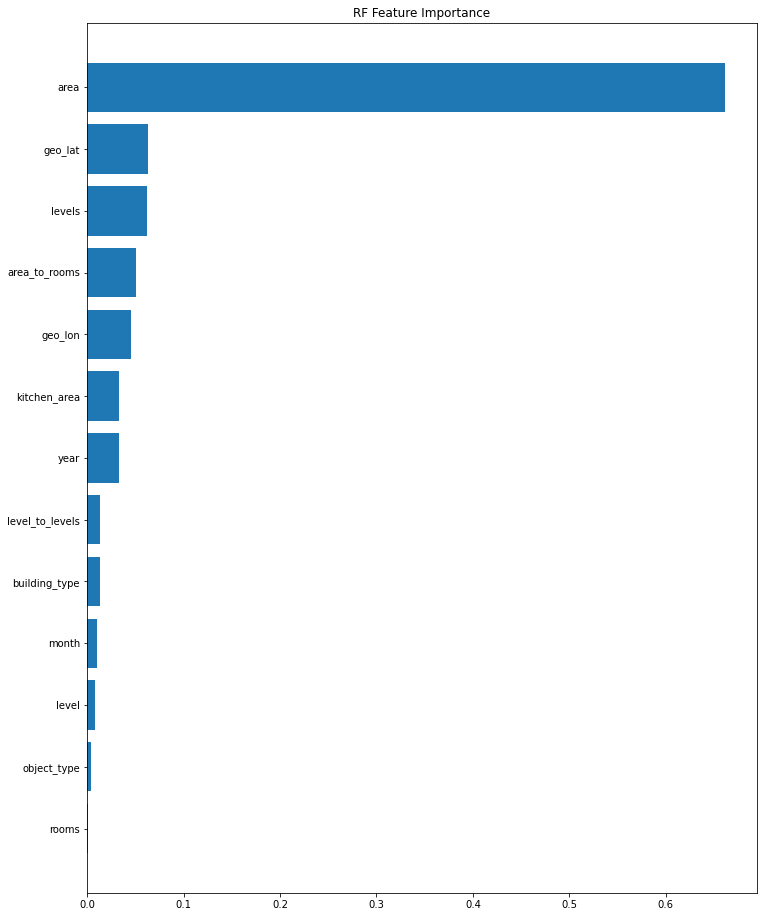

In [19]:
import matplotlib.pyplot as plt

# Display feature importance.
importance = pd.DataFrame({
    'features': X.columns,
    'importance': model1.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('RF Feature Importance')
plt.show()

In [28]:
# Final resulta with CV

result_final = cross_val_score(model_rf, X, y, cv=5)
print(np.mean(result_final))
print(np.std(result_final))

0.8586311222545863
0.05573906204093074


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = model1.predict_proba(X_test)
print("model_rf AUC score:", roc_auc_score(y_test, y_pred_proba))

AttributeError: 'RandomForestRegressor' object has no attribute 'predict_proba'

In [ ]:
# visualizing AUC model comparison
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba1[:, 1])
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_proba2[:, 1])

plt.plot(fpr, tpr)
plt.plot(fpr1, tpr1)
plt.show()

In [29]:
# Safe the model
import joblib

filename = 'model_rf.sav'
joblib.dump(model_rf, filename)

['model_rf.sav']

In [30]:
# load the model from disk
loaded_model = joblib.load(filename)